# Plotting Notebook

This notebook aims to generate main figures from the paper.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

fontsize = 20
ticksize = 16
markersize = 50
linewidth = 3

**NOTE:** select AVX versions available on the host CPU. Available instructions can be found by running `lscpu`.

In [2]:
# At least one should be true
AVX2 = True
AVX512 = True       # Enable if avx512f is available
IFMA = True         # Enable if avx512ifma is available

OPENSSL = True      # Enable if OpenSSL is installed
HACL = True         # Enable if hacl-star is installed

## Prime Field Sweep

Here we plot Figure 5 from the paper.

Load all the csv files from sphgen_benchmarks. Make sure to run `./bench_sphgen.sh`

In [3]:
# These are utility functions to load dataframes from the results directorys
def load_df(directory, prefix, ifma=False, kara=False, max_unroll=8):
    # list all the files in the directory
    files = os.listdir(directory)
    
    if ifma:
        start = 2
    else:
        start = 1

    # pi, theta, l, u, simd, degree, bytes read, cycles, model, actual
    df = None


    filtered_files = []
    for f in files:
        to_add = True
        if prefix in f:
            if ifma and 'ifma' not in f:
                to_add = False
            if kara and 'kara' not in f:
                to_add = False
            if not ifma and 'ifma' in f:
                to_add = False
            if not kara and 'kara' in f:
                to_add = False
            if to_add:
                filtered_files.append(f)

    for f in filtered_files:
        stripped = f.split('.')[0]
        if df is None:
            unroll = stripped.split('_')[start][1:]
            if int(unroll) > max_unroll:
                continue
            df = pd.read_csv(directory + "/" + f, header=None)
            df.columns = ['pi', 'theta', 'l', 'u_' + unroll, 'simd', 'degree', 'bytes read', 'cycles_' + unroll, 'model_' + unroll, 'actual', 'err', 'rel err', 'err / u']
            df['predicted_' + unroll] = df['model_' + unroll] * ((df['degree'] - df['simd']) / (df['u_' + unroll].astype(int) * df['simd'].astype(int)))
            df.drop(columns=['l', 'actual', 'err', 'rel err', 'err / u'], inplace=True)
        else:
            unroll = stripped.split('_')[start][1:]
            if int(unroll) > max_unroll:
                continue
            temp = pd.read_csv(directory + "/" + f, header=None)
            temp.columns = ['pi', 'theta', 'l', 'u_' + unroll, 'simd', 'degree', 'bytes read', 'cycles_' + unroll, 'model_' + unroll, 'actual', 'err', 'rel err', 'err / u']
            temp['predicted_' + unroll] = temp['model_' + unroll] * ((temp['degree'] - temp['simd']) // (temp['u_' + unroll].astype(int) * temp['simd'].astype(int)))
            temp.drop(columns=['l', 'actual', 'err', 'rel err', 'err / u'], inplace=True)
            # join the dataframes based on pi, theta, l, u, degree
            df = pd.merge(df, temp, on=['pi', 'theta', 'degree', 'simd', 'bytes read'], suffixes=('', ''))

    # get all the columns that start by cycles
    cycles = [col for col in df.columns if 'cycles' in col]
    df['best_cycles'] = df[cycles].min(axis=1)
    df['best_predicted'] = df[[col for col in df.columns if 'predicted' in col]].min(axis=1)

    df['cycles_per_byte'] = df['best_cycles'] / df['bytes read']
    df['predicted_cycles_per_byte'] = df['best_predicted'] / df['bytes read']

    # draw a line that connects the sequence of minimum cycles per byte
    pareto_val = 1e10
    pareto_front = []
    # iterate over cycles per byte from last row to first
    for i in range(df.shape[0] - 1, 0, -1):
        if df.iloc[i]['cycles_per_byte'] < pareto_val and df.iloc[i]['pi'] < 398:
            pareto_val = df.iloc[i]['cycles_per_byte']
            # append (pi, cycles per byte) to pareto front
            pareto_front.append((df.iloc[i]['pi'], df.iloc[i]['cycles_per_byte']))

    # reverse the pareto front
    rev_pareto_front = pareto_front[::-1]

    pareto_front_plot = []
    for i in range(1, len(rev_pareto_front)):
        pareto_front_plot.append((rev_pareto_front[i-1][0], rev_pareto_front[i][1]))
        pareto_front_plot.append((rev_pareto_front[i][0], rev_pareto_front[i][1]))

    predicted_pareto_val = 1e10
    predicted_pareto_front = []
    # iterate over cycles per byte from last row to first
    for i in range(df.shape[0] - 1, 0, -1):
        if df.iloc[i]['predicted_cycles_per_byte'] < predicted_pareto_val and df.iloc[i]['pi'] < 398:
            predicted_pareto_val = df.iloc[i]['predicted_cycles_per_byte']
            # append (pi, cycles per byte) to pareto front
            predicted_pareto_front.append((df.iloc[i]['pi'], df.iloc[i]['predicted_cycles_per_byte']))

    # reverse the pareto front
    rev_predicted_pareto_front = predicted_pareto_front[::-1]

    predicted_pareto_front_plot = []
    for i in range(1, len(rev_predicted_pareto_front)):
        predicted_pareto_front_plot.append((rev_predicted_pareto_front[i-1][0], rev_predicted_pareto_front[i][1]))
        predicted_pareto_front_plot.append((rev_predicted_pareto_front[i][0], rev_predicted_pareto_front[i][1]))

    return df, pareto_front_plot, predicted_pareto_front_plot


def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [4]:
directory = "sphgen_benchmarks"

df_s4, pareto_front_s4, predicted_pareto_s4 = load_df(directory, 's4', kara=False)

if AVX512:
    df_s8, pareto_front_s8, predicted_pareto_s8 = load_df(directory, 's8', kara=False)

if IFMA:
    df_s8_ifma, pareto_front_s8_ifma, predicted_pareto_s8_ifma = load_df(directory, 's8_ifma', ifma=True, kara=False)

df_s4_kara, pareto_front_s4_kara, predicted_pareto_s4_kara = load_df(directory, 's4', kara=True)

if AVX512:
    df_s8_kara, pareto_front_s8_kara, predicted_pareto_s8_kara = load_df(directory, 's8', kara=True)

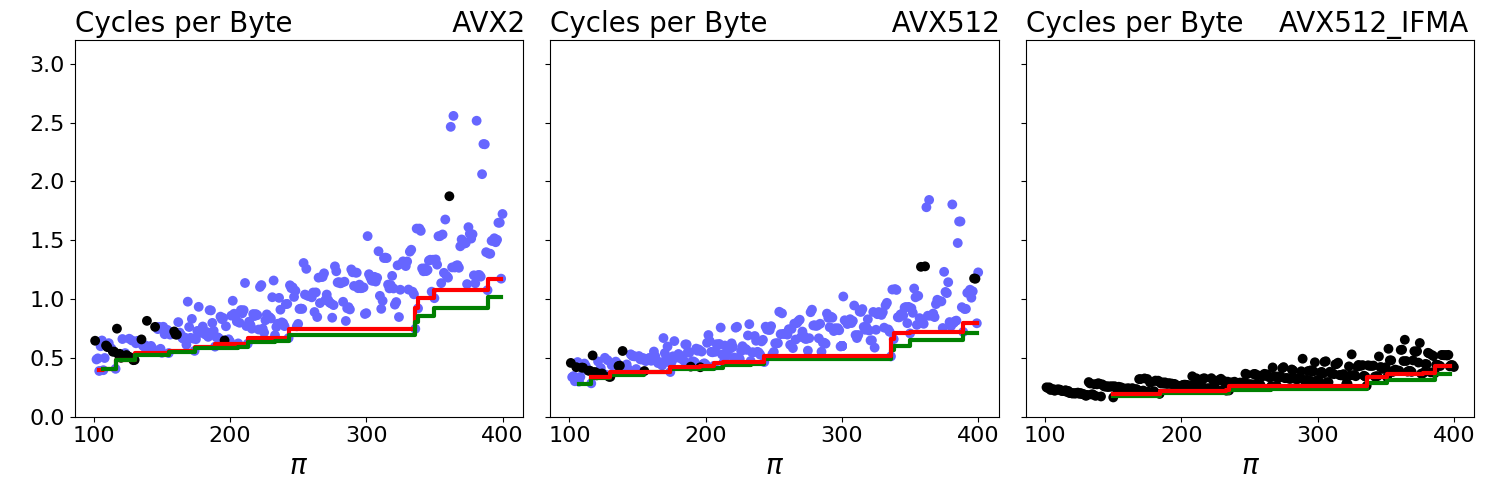

In [5]:
# PLOT KARA AND SCHOOLBOOK IN DIFFERENT COLORS

df_s4_both = pd.merge(df_s4, df_s4_kara, on=['pi', 'theta', 'degree', 'bytes read'], suffixes=('_s4', '_s4_kara'))
df_s4_both['best_cycles'] = df_s4_both[['best_cycles_s4', 'best_cycles_s4_kara']].min(axis=1)
df_s4_both['best_predicted_cycles_per_byte'] = df_s4_both[['predicted_cycles_per_byte_s4', 'predicted_cycles_per_byte_s4_kara']].min(axis=1)
df_s4_both['which'] = np.where(df_s4_both['best_cycles_s4'] < df_s4_both['best_cycles_s4_kara'], 'schoolbook', 'kara')
df_s4_both['cycles_per_byte'] = df_s4_both['best_cycles'] / df_s4_both['bytes read']

if AVX512:
    df_s8_both = pd.merge(df_s8, df_s8_kara, on=['pi', 'theta', 'degree', 'bytes read'], suffixes=('_s8', '_s8_kara'))
    df_s8_both['best_cycles'] = df_s8_both[['best_cycles_s8', 'best_cycles_s8_kara']].min(axis=1)
    df_s8_both['best_predicted_cycles_per_byte'] = df_s8_both[['predicted_cycles_per_byte_s8', 'predicted_cycles_per_byte_s8_kara']].min(axis=1)
    df_s8_both['which'] = np.where(df_s8_both['best_cycles_s8'] < df_s8_both['best_cycles_s8_kara'], 'schoolbook', 'kara')
    df_s8_both['cycles_per_byte'] = df_s8_both['best_cycles'] / df_s8_both['bytes read']

max_pareto = 400

pareto_val_s4_both = 1e10
pareto_front_s4_both = []
for i in range(df_s4_both.shape[0] - 1, 0, -1):
    if df_s4_both.iloc[i]['cycles_per_byte'] < pareto_val_s4_both and df_s4_both.iloc[i]['pi'] < max_pareto:
        pareto_val_s4_both = df_s4_both.iloc[i]['cycles_per_byte']
        pareto_front_s4_both.append((df_s4_both.iloc[i]['pi'], df_s4_both.iloc[i]['cycles_per_byte']))

if AVX512:
    pareto_val_s8_both = 1e10
    pareto_front_s8_both = []
    for i in range(df_s8_both.shape[0] - 1, 0, -1):
        if df_s8_both.iloc[i]['cycles_per_byte'] < pareto_val_s8_both and df_s8_both.iloc[i]['pi'] < max_pareto:
            pareto_val_s8_both = df_s8_both.iloc[i]['cycles_per_byte']
            pareto_front_s8_both.append((df_s8_both.iloc[i]['pi'], df_s8_both.iloc[i]['cycles_per_byte']))

predicted_pareto_val_s4_both = 1e10
predicted_pareto_front_s4_both = []
for i in range(df_s4_both.shape[0] - 1, 0, -1):
    if df_s4_both.iloc[i]['best_predicted_cycles_per_byte'] < predicted_pareto_val_s4_both and df_s4_both.iloc[i]['pi'] < max_pareto:
        predicted_pareto_val_s4_both = df_s4_both.iloc[i]['best_predicted_cycles_per_byte']
        predicted_pareto_front_s4_both.append((df_s4_both.iloc[i]['pi'], df_s4_both.iloc[i]['best_predicted_cycles_per_byte']))

if AVX512:
    predicted_pareto_val_s8_both = 1e10
    predicted_pareto_front_s8_both = []
    for i in range(df_s8_both.shape[0] - 1, 0, -1):
        if df_s8_both.iloc[i]['best_predicted_cycles_per_byte'] < predicted_pareto_val_s8_both and df_s8_both.iloc[i]['pi'] < max_pareto:
            predicted_pareto_val_s8_both = df_s8_both.iloc[i]['best_predicted_cycles_per_byte']
            predicted_pareto_front_s8_both.append((df_s8_both.iloc[i]['pi'], df_s8_both.iloc[i]['best_predicted_cycles_per_byte']))

rev_pareto_front_s4_both = pareto_front_s4_both[::-1]

# change pareto front to have straight lines
pareto_front_s4_both_plot = []
for i in range(1, len(rev_pareto_front_s4_both)):
    pareto_front_s4_both_plot.append((rev_pareto_front_s4_both[i-1][0], rev_pareto_front_s4_both[i][1]))
    pareto_front_s4_both_plot.append((rev_pareto_front_s4_both[i][0], rev_pareto_front_s4_both[i][1]))

if AVX512:
    rev_pareto_front_s8_both = pareto_front_s8_both[::-1]
    pareto_front_s8_both_plot = []
    for i in range(1, len(rev_pareto_front_s8_both)):
        pareto_front_s8_both_plot.append((rev_pareto_front_s8_both[i-1][0], rev_pareto_front_s8_both[i][1]))
        pareto_front_s8_both_plot.append((rev_pareto_front_s8_both[i][0], rev_pareto_front_s8_both[i][1]))

rev_predicted_pareto_front_s4_both = predicted_pareto_front_s4_both[::-1]

predicted_pareto_front_s4_both_plot = []
for i in range(1, len(rev_predicted_pareto_front_s4_both)):
    predicted_pareto_front_s4_both_plot.append((rev_predicted_pareto_front_s4_both[i-1][0], rev_predicted_pareto_front_s4_both[i][1]))
    predicted_pareto_front_s4_both_plot.append((rev_predicted_pareto_front_s4_both[i][0], rev_predicted_pareto_front_s4_both[i][1]))

if AVX512:
    rev_predicted_pareto_front_s8_both = predicted_pareto_front_s8_both[::-1]

    predicted_pareto_front_s8_both_plot = []
    for i in range(1, len(rev_predicted_pareto_front_s8_both)):
        predicted_pareto_front_s8_both_plot.append((rev_predicted_pareto_front_s8_both[i-1][0], rev_predicted_pareto_front_s8_both[i][1]))
        predicted_pareto_front_s8_both_plot.append((rev_predicted_pareto_front_s8_both[i][0], rev_predicted_pareto_front_s8_both[i][1]))

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_size_inches(15, 5)

ax0.set_ylabel(' ', fontsize=10)

fontsize = 20
ticksize = 16
markersize = 50
linewidth = 3
sns.lineplot(x=[x[0] for x in pareto_front_s4_both_plot], y=[x[1] for x in pareto_front_s4_both_plot], color='red', linewidth=linewidth, ax=ax0, errorbar=None, estimator=None, sort=False)
sns.lineplot(x=[x[0] for x in predicted_pareto_front_s4_both_plot], y=[x[1] for x in predicted_pareto_front_s4_both_plot], color='green', linewidth=linewidth, ax=ax0, errorbar=None, estimator=None, sort=False)
sns.scatterplot(x='pi', y='cycles_per_byte', data=df_s4_both[df_s4_both['which'] == 'kara'], ax=ax0, color=lighten_color('b', 0.6), marker='o', s=markersize, edgecolor='none')
sns.scatterplot(x='pi', y='cycles_per_byte', data=df_s4_both[df_s4_both['which'] == 'schoolbook'], ax=ax0, color='black', marker='o', s=markersize, edgecolor='none')
ax0.set_xlabel('')
ax0.set_title('Cycles per Byte                  AVX2', loc='left', fontsize=fontsize)
ax0.tick_params(axis='both', which='major', labelsize=ticksize)
ax0.set_xlabel(r'$\pi$', fontsize=fontsize)
ax0.set_ylim(0, 3.2)

if AVX512:
    sns.lineplot(x=[x[0] for x in predicted_pareto_front_s8_both_plot], y=[x[1] for x in predicted_pareto_front_s8_both_plot], color='green', linewidth=linewidth, ax=ax1,  errorbar=None, estimator=None, sort=False)
    sns.lineplot(x=[x[0] for x in pareto_front_s8_both_plot], y=[x[1] for x in pareto_front_s8_both_plot], color='red', linewidth=linewidth, ax=ax1,  errorbar=None, estimator=None, sort=False)
    sns.scatterplot(x='pi', y='cycles_per_byte', data=df_s8_both[df_s8_both['which'] == 'kara'], ax=ax1, color=lighten_color('b', 0.6), marker='o', s=markersize, edgecolor='none')
    sns.scatterplot(x='pi', y='cycles_per_byte', data=df_s8_both[df_s8_both['which'] == 'schoolbook'], ax=ax1, color='black', marker='o', s=markersize, edgecolor='none')
ax1.set_xlabel('')
ax1.set_title('Cycles per Byte              AVX512', loc='left', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=ticksize)
ax1.set_xlabel(r'$\pi$', fontsize=fontsize)

if IFMA:
    sns.lineplot(x=[x[0] for x in predicted_pareto_s8_ifma], y=[x[1] for x in predicted_pareto_s8_ifma], color='green', linewidth=linewidth, ax=ax2,  errorbar=None, estimator=None, sort=False)
    sns.lineplot(x=[x[0] for x in pareto_front_s8_ifma], y=[x[1] for x in pareto_front_s8_ifma], color='red', linewidth=linewidth, ax=ax2,  errorbar=None, estimator=None, sort=False)
    sns.scatterplot(x='pi', y='cycles_per_byte', data=df_s8_ifma, ax=ax2, color='black', markers=True, marker='o', s=markersize, edgecolor='none')
ax2.set_xlabel('')
ax2.set_title('Cycles per Byte    AVX512_IFMA', loc='left', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=ticksize)
ax2.set_xlabel(r'$\pi$', fontsize=fontsize)
plt.tight_layout()

# Compare poly1305

Here we generate figure 7a from the paper.

Load all the csv files from poly1305_benchmarks. Make sure to run `./bench_poly1305.sh`

In [6]:
directory = "poly1305_benchmarks"
if HACL:
    df_hacl = pd.read_csv(os.path.join(directory, "hacl.csv"))
if OPENSSL:
    if AVX2:
        df_openssl_avx2 = pd.read_csv(os.path.join(directory, "openssl_avx2.csv"))
    if AVX512:
        df_openssl_avx512 = pd.read_csv(os.path.join(directory, "openssl_avx512.csv"))
    if IFMA:
        df_openssl_ifma = pd.read_csv(os.path.join(directory, "openssl_avx512ifma.csv"))

Us = [2, 4, 8]          # unrollings, hardcoded in this example
df_sphgen_avx2 = []
df_sphgen_avx512 = []
df_sphgen_ifma = []

for U in Us:
    if AVX2:
        df_sphgen_avx2.append(pd.read_csv(os.path.join(directory, f"poly1305_s4_u{U}.csv")))
    if AVX512:
        df_sphgen_avx512.append(pd.read_csv(os.path.join(directory, f"poly1305_s8_u{U}.csv")))
    if IFMA:
        df_sphgen_ifma.append(pd.read_csv(os.path.join(directory, f"poly1305_s8_ifma_u{U}.csv")))

for U in Us:
    if AVX2:
        df_sphgen_avx2.append(pd.read_csv(os.path.join(directory, f"poly1305_s4_u{U}_kara.csv")))
    if AVX512:
        df_sphgen_avx512.append(pd.read_csv(os.path.join(directory, f"poly1305_s8_u{U}_kara.csv")))

For SPHGen, get the minimum cycles among all versions

In [7]:
df = None
if AVX2:
    s4 = pd.concat(df_sphgen_avx2, ignore_index=True) \
        .groupby('bytes', as_index=False)['cycles'] \
        .min() \
        .rename(columns={'cycles': 's4'})
    df = s4
if AVX512:
    s8 = pd.concat(df_sphgen_avx512, ignore_index=True) \
        .groupby('bytes', as_index=False)['cycles'] \
        .min() \
        .rename(columns={'cycles': 's8'})
    if df is None:
        df = s8
    else:
        df = df.merge(s8, on='bytes')
if IFMA:
    s8_ifma = pd.concat(df_sphgen_ifma, ignore_index=True) \
        .groupby('bytes', as_index=False)['cycles'] \
        .min() \
        .rename(columns={'cycles': 'ifma'})
    if df is None:
        df = s8_ifma
    else:
        df = df.merge(s8_ifma, on='bytes')  
if HACL:
    df['hacl'] = df_hacl['cycles']

if OPENSSL:
    if AVX2:
        df['openssl_avx2'] = df_openssl_avx2['cycles']
    if AVX512:
        df['openssl_avx512'] = df_openssl_avx512['cycles']
    if IFMA:
        df['openssl_ifma'] = df_openssl_ifma['cycles']

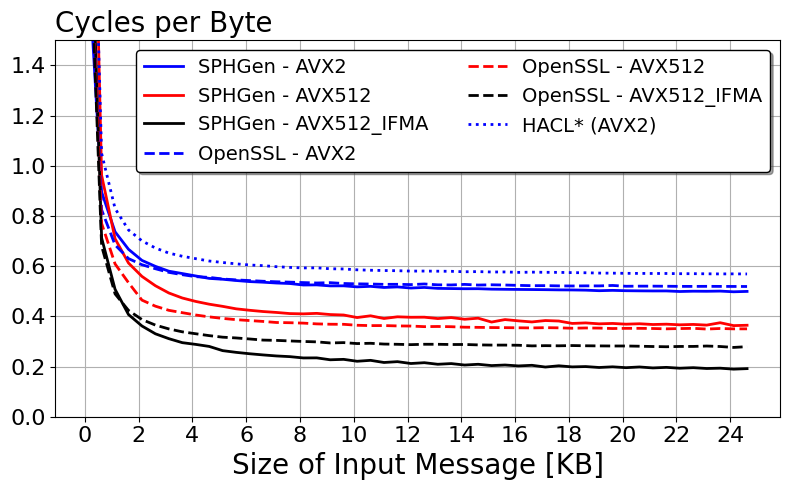

In [8]:
if AVX2:
    df['s4_over_len'] = df['s4'] / df['bytes']
if AVX512:
    df['s8_over_len'] = df['s8'] / df['bytes']
if IFMA:
    df['ifma_over_len'] = df['ifma'] / df['bytes']

if OPENSSL:
    if AVX2:
        df['openssl_avx2_over_len'] = df['openssl_avx2'] / df['bytes']
    if AVX512:
        df['openssl_avx512_over_len'] = df['openssl_avx512'] / df['bytes']
    if IFMA:
        df['openssl_ifma_over_len'] = df['openssl_ifma'] / df['bytes']
if HACL:
    df['hacl_over_len'] = df['hacl'] / df['bytes']
# df['jasmin_over_len'] = df['jasmin'] / df['bytes']
fig = plt.figure(figsize=(8, 5))

# plot each line separately

width = 2
markersize = 5
if AVX2:
    sns.lineplot(x='bytes', y='s4_over_len', data=df, linestyle='solid', linewidth=width, markersize=markersize, label='SPHGen - AVX2', color='blue')
if AVX512:
    sns.lineplot(x='bytes', y='s8_over_len', data=df, linestyle='solid', linewidth=width, markersize=markersize, label='SPHGen - AVX512', color='red')
if IFMA:
    sns.lineplot(x='bytes', y='ifma_over_len', data=df, linestyle='solid', linewidth=width, markersize=markersize, label='SPHGen - AVX512_IFMA', color='black')
if OPENSSL:
    if AVX2:
        sns.lineplot(x='bytes', y='openssl_avx2_over_len', data=df, linestyle='dashed', linewidth=width, markersize=markersize, label='OpenSSL - AVX2', color='blue')
    if AVX512:
        sns.lineplot(x='bytes', y='openssl_avx512_over_len', data=df, linestyle='dashed', linewidth=width, markersize=markersize, label='OpenSSL - AVX512', color='red')
    if IFMA:
        sns.lineplot(x='bytes', y='openssl_ifma_over_len', data=df, linestyle='dashed', linewidth=width, markersize=markersize, label='OpenSSL - AVX512_IFMA', color='black')
# plot hacl
if HACL:
    sns.lineplot(x='bytes', y='hacl_over_len', data=df, linestyle='dotted', linewidth=width, markersize=markersize, label='HACL* (AVX2)', color='blue')

# plt.legend(['AVX2', 'AVX512', 'AVX512_IFMA', 'OpenSSL'])


# add grid
plt.grid(True)

# put xticks every 2048
plt.xticks(np.arange(0, 25216, 2048), labels=[str(v) for v in range(0, 26, 2)], fontsize=ticksize)
plt.yticks(fontsize=ticksize)

# remove box from legend and put a white background
# plt.legend(fontsize=fontsize, frameon=True, fancybox=True, facecolor='white', edgecolor='black', shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(fontsize=14, frameon=True, fancybox=True, facecolor='white', edgecolor='black', shadow=True,  loc='upper right', ncol=2)

# set y limit
plt.ylim(0, 1.5)

plt.ylabel('')
plt.xlabel('Size of Input Message [KB]', fontsize=fontsize)
plt.title('Cycles per Byte', loc='left', fontsize=fontsize)

fig.tight_layout()
# plt.savefig('./figures/comparison.pdf')

# Plot Model Accuracy

Here we plot figure 6 from the paper. 
> **Note**: our performance model is tuned for Sapphire Rapids CPUs

In [9]:
directory = "sphgen_benchmarks"

df_s4_kara_model = pd.read_csv(f'{directory}/s4_u1_kara.csv')
df_s4_kara_model.columns = ['pi', 'theta', 'l', 'u', 'simd', 'degree', 'bytes read', 'cycles', 'model', 'actual', 'err', 'rel err', 'err / u']
df_s4_kara_model.drop(columns=['degree', 'bytes read', 'l', 'u', 'simd', 'err', 'rel err', 'err / u'], inplace=True)

df_s4_schoolbook_model = pd.read_csv(f'{directory}/s4_u1.csv')
df_s4_schoolbook_model.columns = ['pi', 'theta', 'l', 'u', 'simd', 'degree', 'bytes read', 'cycles', 'model', 'actual', 'err', 'rel err', 'err / u']
df_s4_schoolbook_model.drop(columns=['degree', 'bytes read', 'l', 'u', 'simd', 'err', 'rel err', 'err / u'], inplace=True)

df_s4_model = pd.merge(df_s4_kara_model, df_s4_schoolbook_model, on=['pi', 'theta'], suffixes=('_kara', '_schoolbook'))

# for each row, select the lowest cycles. If the lowest is from kara write 'kara' in which column, otherwise write 'schoolbook'
df_s4_model['best_cycles'] = df_s4_model.apply(lambda x: min(x['cycles_kara'], x['cycles_schoolbook']), axis=1)
df_s4_model['best_model'] = df_s4_model.apply(lambda x: 'kara' if x['cycles_kara'] < x['cycles_schoolbook'] else 'schoolbook', axis=1)

if AVX512:
    df_s8_kara_model = pd.read_csv(f'{directory}/s8_u1_kara.csv')
    df_s8_kara_model.columns = ['pi', 'theta', 'l', 'u', 'simd', 'degree', 'bytes read', 'cycles', 'model', 'actual', 'err', 'rel err', 'err / u']
    df_s8_kara_model.drop(columns=['degree', 'bytes read', 'l', 'u', 'simd', 'err', 'rel err', 'err / u'], inplace=True)

    df_s8_schoolbook_model = pd.read_csv(f'{directory}/s8_u1.csv')
    df_s8_schoolbook_model.columns = ['pi', 'theta', 'l', 'u', 'simd', 'degree', 'bytes read', 'cycles', 'model', 'actual', 'err', 'rel err', 'err / u']
    df_s8_schoolbook_model.drop(columns=['degree', 'bytes read', 'l', 'u', 'simd', 'err', 'rel err', 'err / u'], inplace=True)

    df_s8_model = pd.merge(df_s8_kara_model, df_s8_schoolbook_model, on=['pi', 'theta'], suffixes=('_kara', '_schoolbook'))

    df_s8_model['best_cycles'] = df_s8_model.apply(lambda x: min(x['cycles_kara'], x['cycles_schoolbook']), axis=1)
    df_s8_model['best_model'] = df_s8_model.apply(lambda x: 'kara' if x['cycles_kara'] < x['cycles_schoolbook'] else 'schoolbook', axis=1)

if IFMA:
    df_s8_ifma = pd.read_csv(f'{directory}/s8_ifma_u1.csv')
    df_s8_ifma.columns = ['pi', 'theta', 'l', 'u', 'simd', 'degree', 'bytes read', 'cycles', 'model', 'actual', 'err', 'rel err', 'err / u']
    df_s8_ifma.drop(columns=['degree', 'bytes read', 'l', 'u', 'simd', 'err', 'rel err', 'err / u'], inplace=True)

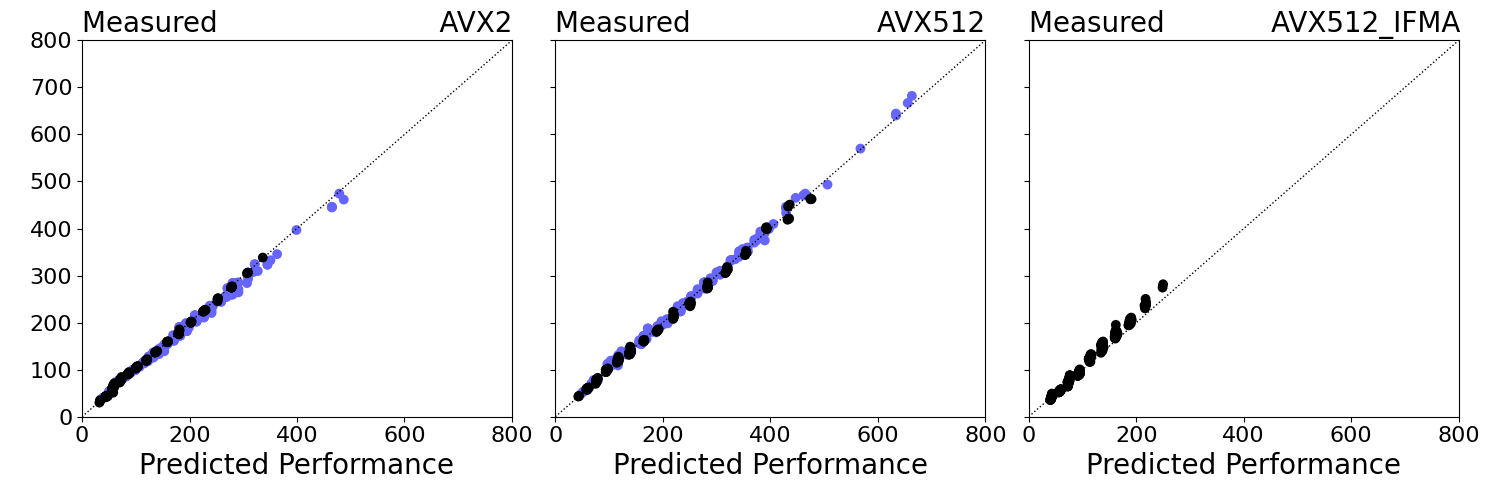

In [10]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_size_inches(15, 5)

ax0.set_ylabel(' ', fontsize=10)

size = 50
limit = 800
linewidth = 1
# set limits for x and y axis
ax0.set_xlim([0, limit])
ax0.set_ylim([0, limit])

# make a diagonal line
ax0.plot([0, limit], [0, limit], color='black', linestyle='dotted', linewidth=linewidth)
ax1.plot([0, limit], [0, limit], color='black', linestyle='dotted', linewidth=linewidth)
ax2.plot([0, limit], [0, limit], color='black', linestyle='dotted', linewidth=linewidth)

sns.scatterplot(x='model_kara', y='actual_kara', data=df_s4_model[df_s4_model['best_model'] == 'kara'], ax=ax0, color=lighten_color('b', 0.6), markers=True, marker='o', s=size, edgecolor='none')
sns.scatterplot(x='model_schoolbook', y='actual_schoolbook', data=df_s4_model[df_s4_model['best_model'] == 'schoolbook'], ax=ax0, color='black', markers=True, marker='o', s=size, edgecolor='none')
ax0.set_xlabel('Predicted Performance', fontsize=fontsize)
ax0.set_title('Measured                         AVX2', loc='left', fontsize=fontsize)
ax0.tick_params(axis='both', which='major', labelsize=ticksize)

if AVX512:
    sns.scatterplot(x='model_kara', y='actual_kara', data=df_s8_model[df_s8_model['best_model'] == 'kara'], ax=ax1, color=lighten_color('b', 0.6), markers=True, marker='o', s=size, edgecolor='none')
    sns.scatterplot(x='model_schoolbook', y='actual_schoolbook', data=df_s8_model[df_s8_model['best_model'] == 'schoolbook'], ax=ax1, color='black', markers=True, marker='o', s=size, edgecolor='none')
ax1.set_xlabel('Predicted Performance', fontsize=fontsize)
ax1.set_title('Measured                     AVX512', loc='left', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=ticksize)

if IFMA:
    sns.scatterplot(x='model', y='actual', data=df_s8_ifma, ax=ax2, color='black', markers=True, marker='o', s=size, edgecolor='none')
ax2.set_xlabel('Predicted Performance', fontsize=fontsize)
ax2.set_title('Measured            AVX512_IFMA', loc='left', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=ticksize)


plt.tight_layout()